In [1]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from numpy.random import dirichlet as diri

dl = DataLib("SignalData")

In [2]:
# Pull all the necessary dataframes to avoid duplicate code. 
BondRetIdx = dl.pull("BondRetIdx/LocalFX")
LongRates = dl.pull("LongRates")
ShortRates = dl.pull("ShortRates")
EquityPrices = dl.pull("EquityPrices")
M1 = dl.pull("M1/inUSD")
M2 = dl.pull("M2/inUSD")
M3 = dl.pull("M3/inUSD")
CurrAcctNom = dl.pull("CurrAcctNom/inUSD")
CurrAcctPctGDP = dl.pull("CurrAcctPctGDP")
nGDP = dl.pull("GDP/Nominal")
rGDP = dl.pull("GDP/Real")
nFxTrdWts = dl.pull("fxTrdWts/Nominal")
rFxTrdWts = dl.pull("fxTrdWts/Real")
fxVsUSD = dl.pull("fxVsUSD")
CoreCPI = dl.pull("CoreCPI/SA")

In [10]:
# Constants. 
WORKDAYS_IN_MONTH=21
WORKDAYS_IN_YEAR=261
QUARTERS_IN_YEAR=4
COUNTRIES=[
    'USA', 'AUS', 'JPN', 'CAN', 'CHE', 'GBR', 'ESP', 'FRA', 'ITA', 'DEU'
]

# 0. Overview
Here we look at using money supply as an indicator. 

# 1. Money Supply and Bond Returns
As we are trying to predict bond returns, let's see if we can discern a relationship between them. 


In [56]:
# Let's formulate what we want to use as money supply. 
M1_change = M1.pct_change()
M2_change = M2.pct_change()
M3_change = M3.pct_change()

# Use a combination of M1 and M3 for Australia (as it's missing M2). 
ms_chg = M2_change
ms_chg['AUS'] = 0.5 * M1_change['AUS'] + 0.5 * M3_change['AUS']

Let's use the change of the last 3 months compared to the change in the last 12 months. 

In [57]:
ms_chg_3mo = ms_chg.rolling(3).mean()
ms_chg_12mo = ms_chg.rolling(12).mean()
ms_chg_diff = ms_chg_3mo - ms_chg_12mo
ms_chg_diff = ms_chg_diff.ewm(3).mean()

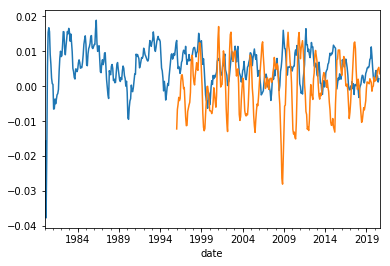

In [58]:
# Take the change in returns, then smooth. 
bri = BondRetIdx
bri_chg = bri.resample('M').mean().pct_change()
bri_chg_ewm = bri_change.ewm(span=12).mean() # EWM - 12 month. 

# Plot the change in returns alongside the change difference in MS. 
bri_chg_ewm['DEU'].plot()
ms_chg_diff['DEU'].plot()

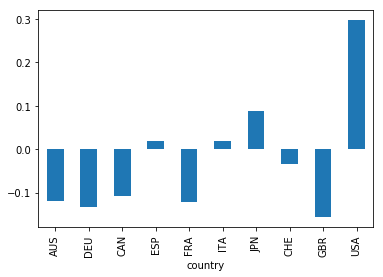

In [59]:
bri_chg_ewm.corrwith(ms_chg_diff).plot.bar()

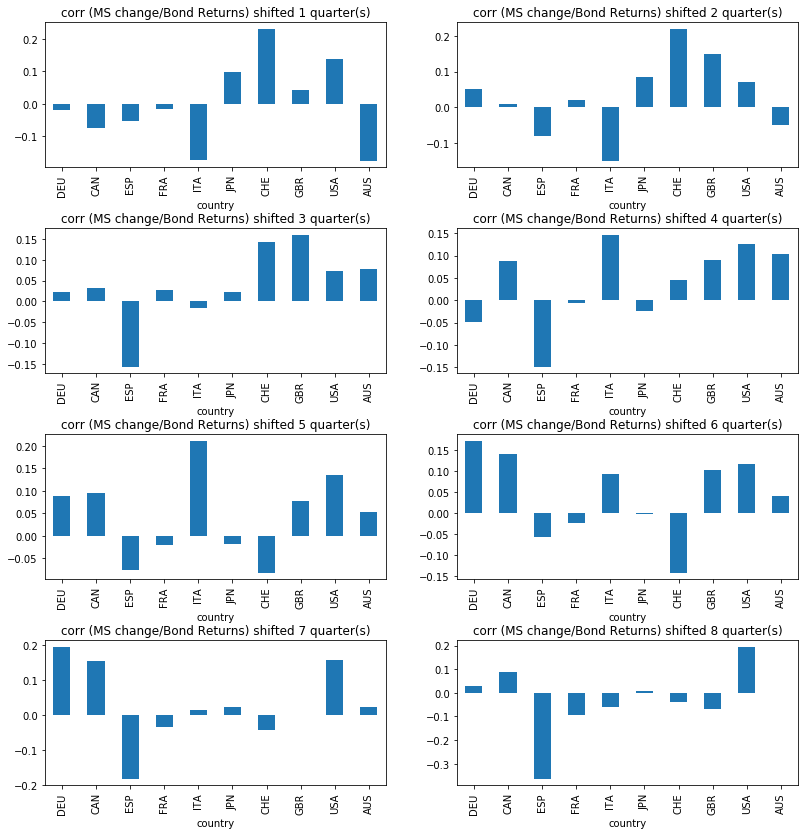

In [60]:
ms_chg_ewm_shifted = ms_chg_ewm

# Plot the correlation. 
fig, axs = plt.subplots(4, 2, figsize=(12, 12))
fig.tight_layout(pad=4)
for i, shift in enumerate(range(1, 9)): 
    ax = axs[i//2][i%2]
    ms_chg_ewm_shifted = ms_chg_ewm.shift(shift*4)
    ms_chg_ewm_shifted.corrwith(bri_chg_ewm).plot.bar(ax=ax, title='corr (MS change/Bond Returns) shifted {} quarter(s)'.format(shift))

# 2. Build the indicator

In [61]:
# Get the difference between the 12 and the 3 month money supply change. 
ms_chg_3mo = ms_chg.rolling(3).mean()
ms_chg_12mo = ms_chg.rolling(12).mean()
ms_chg_diff = ms_chg_3mo - ms_chg_12mo
ms_chg_diff = ms_chg_diff.ewm(3).mean()

In [64]:
# For each country (column), get a rolling average for the past 3 years. 
sma = ms_chg_diff.ewm(12).mean()
std = ms_chg_diff.ewm(12).std()

# Turn the change into a zscore. 
zscore = (ms_chg_diff - sma) / std
zscore = zscore.shift(2) # Shift it forward 3 qs. 

# Smooth out the zscore by taking a rolling average for the past 4 qs.
zscore = zscore.rolling(4).mean()

# 3. Return stream

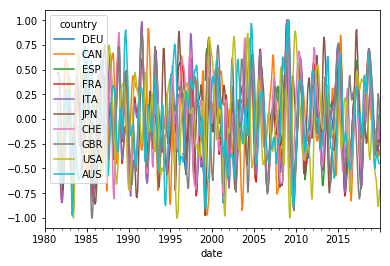

In [73]:
# Convert the z-score to a signal by capping. 
signal = (-1 * zscore).clip(upper=2, lower=-2) / 2
signal = signal.resample('B').interpolate(method='linear')
signal = signal[signal.index < '2020-01-01']
signal.plot()

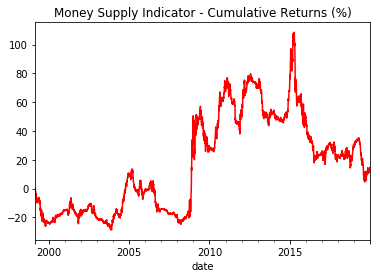

In [77]:
# Calculate cumulative returns. 
returns = BondRetIdx.pct_change().loc[signal.index].shift(-1)
returns = (signal * returns).dropna().sum(axis=1)        
cumul_returns = ((returns + 1).cumprod() - 1) * 100

# Plot. 
cumul_returns.plot(color='red', title="Money Supply Indicator - Cumulative Returns (%)")